In [1]:
import wikipedia
import bs4 as bs 
import urllib.request
from bs4 import BeautifulSoup
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from utils import *


/home/jeanedouard-rgz/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_category(language, subject):
    wikipedia.set_lang(language)
    source = urllib.request.urlopen(wikipedia.page(subject).url).read()
    soup = bs.BeautifulSoup(source,'lxml')
    soup_txt = str(soup.body)
    category = []
    for each_span in soup.find_all('span', {'class':'mw-headline'}):
        soup = BeautifulSoup(str(each_span).replace(' ','_'), "html.parser").getText()
        category.append(soup)
    return category

def get_data(language, subject):
    wikipedia.set_lang(language)
    source = urllib.request.urlopen(wikipedia.page(subject).url).read()
    soup = bs.BeautifulSoup(source,'lxml')
    soup_txt = str(soup.body)
    div = []
    for each_span in soup.find_all('span', {'class':'mw-headline'}):
        str(each_span).replace(' ','_')
        div.append(str(each_span))
    filter_tag = []
    i = 0
    while i < len(div)-1:
        start = div[i]
        end = div[i+1]
        text = soup_txt[soup_txt.find(start)+len(start):soup_txt.rfind(end)]
        soup = str(BeautifulSoup(text, "html.parser"))
        soup = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", soup)
        soup = BeautifulSoup(soup, "html.parser")
        soup = re.compile(r'<img.*?/>').sub('', str(soup.find_all('p')))
        soup = BeautifulSoup(soup, "html.parser")
        soup = (re.sub("[^a-zA-Z,.;:!0-9]"," ",soup.getText()).replace('[','').replace(']','').lstrip().rstrip().lower())    
        clean_text = re.sub(' +', ' ',soup).replace(',',' ')
        filter_tag.append(clean_text)        
        i += 1
    return filter_tag


def get_len_list(filter_tag):
    filtered_text = []
    len_list = []
    i = 0 
    while i < len(filter_tag):
        doc = nlp(filter_tag[i])
        text = [sent.string.strip() for sent in doc.sents]
        filtered_text.append(text)
        len_list.append(len(filtered_text[i]))
        i += 1
    return filtered_text,len_list

def generate_dataset(len_list, category):
    i = 0
    label_list = []
    while i < len(len_list):
        j = 0
        if len_list[i] != 0:
            while j != len_list[i]:
                label_list.append(category[i].lower())
                j += 1
        i += 1
    flat_list = [item for sublist in  get_len_list(get_data(language, subject))[0] for item in sublist]
    data = {'text': flat_list,'label': label_list}
    df = pd.DataFrame.from_dict(data)

    print(df.head())
    print('Repartition of labels:', df['label'].iloc[0])
    print('Data Shape:', df.shape)
    return df

def get_stop_words(language):
    if language == 'en':
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    if language == 'fr':
        spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
    if language == 'de':
        spacy_stopwords = spacy.lang.de.stop_words.STOP_WORDS
    if language == 'es':
        spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS
    if language == 'pt':
        spacy_stopwords = spacy.lang.pt.stop_words.STOP_WORDS
    if language == 'it':
        spacy_stopwords = spacy.lang.it.stop_words.STOP_WORDS
    if language == 'nl':
        spacy_stopwords = spacy.lang.nl.stop_words.STOP_WORDS
    return spacy_stopwords

def clean_dataset(language, df):
    srce_labels = df.label.values.tolist()
    srce_text = df.text.values.tolist()
    spacy_stopwords = get_stop_words(language)
    clean_text = []
    text = []
    
    i = 0
    while i < len(srce_text):
        extract = []
        doc = nlp(srce_text[i])
        for token in doc:
            extract.append(token.lemma_)
        clean_text.append(",".join(extract).replace(","," ").replace("   "," "))
        i += 1
    print('Number of stop words: %d' % len(spacy_stopwords))
    i = 0
    while i < len(clean_text):
        doc = nlp(clean_text[i])
        tokens = [token.text for token in doc if not token.is_stop]
        text.append(",".join(tokens).replace(","," ").replace("  "," ").replace("    "," ").replace("-PRON-"," ").rstrip().lstrip())
        i += 1
    data = {'text': text,'label': srce_labels}
    df = pd.DataFrame.from_dict(data)
    df = df.dropna()
    return df

def create_model(df):
    print("Creating the bag of words...\n")
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 5000) 
    train_data_features = vectorizer.fit_transform(df.text.values.tolist())
    train_data_features = train_data_features.toarray()
    print(train_data_features.shape)
    vocab = vectorizer.get_feature_names()
    dist = np.sum(train_data_features, axis=0)
    print("Training the random forest...")
    forest = RandomForestClassifier(n_estimators = 100) 
    forest = forest.fit(train_data_features, df["label"])
    filename = language+"_"+subject.replace(" ","_")+'.sav'
    pickle.dump(forest, open(filename, 'wb'))
    print('saving model as: '+filename)
    
def call_model(csv_file, model_file, text):
    extract = []
    clean_text = []
    clean_test_reviews = []
    spacy_stopwords = get_stop_words(language)
    print("Creating the bag of words...\n")
    df = pd.read_csv(csv_file) 
    df = df.dropna()
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 5000) 
    train_data_features = vectorizer.fit_transform(df.text.values.tolist())
    train_data_features = train_data_features.toarray()
    print(train_data_features.shape)
    vocab = vectorizer.get_feature_names()
    dist = np.sum(train_data_features, axis=0)
    doc = nlp(text)
    for token in doc:
        extract.append(token.lemma_)
        clean_text.append(",".join(extract).replace(","," ").replace("   "," "))
    print('Number of stop words: %d' % len(spacy_stopwords))
    i = 0
    while i < len(clean_text):
        doc = nlp(clean_text[i])
        tokens = [token.text for token in doc if not token.is_stop]
        i += 1
    clean_test_reviews.append(",".join(tokens).replace(","," ").replace("  "," ").replace("    "," ").replace("-PRON-"," ").rstrip().lstrip())
    test_data_features = vectorizer.transform(clean_test_reviews)
    test_data_features = test_data_features.toarray()
    loaded_model = pickle.load(open(model_file, 'rb'))
    result = loaded_model.predict(test_data_features)
    return result

     label                                               text
0  history  hussars originated in mercenary units of exile...
1  history  serbian lancers  also called racowie  were use...
2  history  the oldest mention of hussars in polish docume...
3  history  in the 15th century  light hussars based on th...
4  history  the polish hussars were originally based on th...
Repartition of labels: history
Data Shape: (91, 2)
Number of stop words: 305
saving dataframe as:  en_polish_hussars.csv


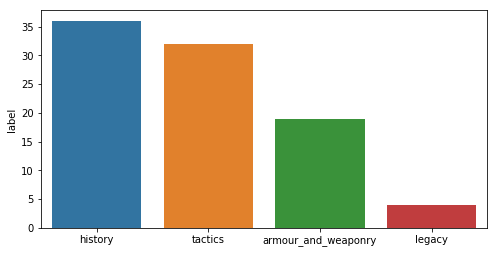

Creating the bag of words...

(91, 535)
Training the random forest...
saving model as: en_polish_hussars.sav


In [3]:
language = 'en'
subject = 'polish hussars'
nlp = spacy.load(language)
df = generate_dataset(get_len_list(get_data(language, subject))[1], get_category(language, subject))
df = clean_dataset(language, df)
file_name = language+"_"+subject.replace(" ","_")+'.csv'
print('saving dataframe as: ',file_name)
df.to_csv(file_name, sep=',', encoding='utf-8')
fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['label'].unique(), y=df['label'].value_counts())
plt.show()

forest = create_model(df)

In [4]:
result = call_model('en_polish_hussars.csv','en_polish_hussars.sav', 'hussar originate mercenary unit exile serbian warrior')

Creating the bag of words...

(91, 535)
Number of stop words: 305


In [5]:
print(result)

['history']
